Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


341/341 ━━━━━━━━━━━━━━━━━━━━ 68s 189ms/step - loss: 0.0148 - val_loss: 0.0024
Epoch 2/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 65s 190ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 3/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 65s 192ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 4/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 65s 191ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 5/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 81s 189ms/step - loss: 9.8354e-04 - val_loss: 0.0022
Epoch 6/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 64s 188ms/step - loss: 8.7722e-04 - val_loss: 0.0022
Epoch 7/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 189ms/step - loss: 9.1361e-04 - val_loss: 0.0019
Epoch 8/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 82s 190ms/step - loss: 8.9248e-04 - val_loss: 0.0019
Epoch 9/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 65s 191ms/step - loss: 8.5000e-04 - val_loss: 0.0019
Epoch 10/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 81s 187ms/step - loss: 8.3044e-04 - val_loss: 0.0020
Epoch 11/30
341/341 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - loss: 7.9048e-04 - val_loss: 0.0019
Ep

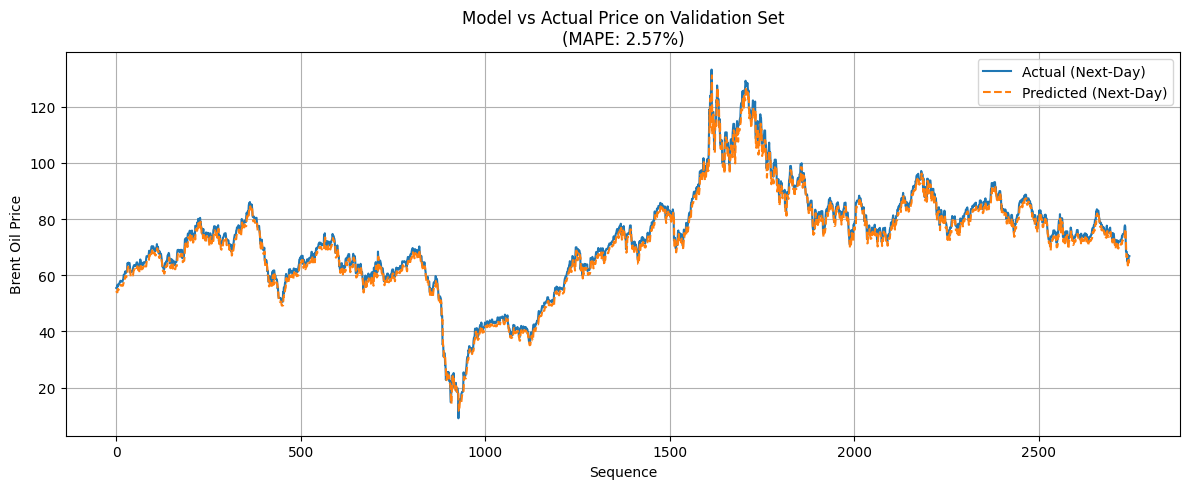

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


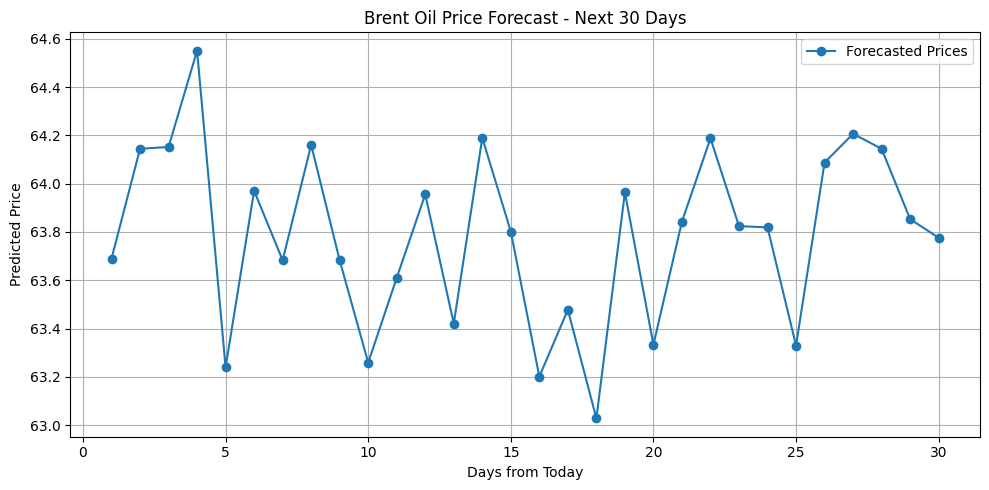


30-Day Brent Oil Price Forecast:
Day 1: $63.69
Day 2: $64.14
Day 3: $64.15
Day 4: $64.55
Day 5: $63.24
Day 6: $63.97
Day 7: $63.68
Day 8: $64.16
Day 9: $63.68
Day 10: $63.26
Day 11: $63.61
Day 12: $63.96
Day 13: $63.42
Day 14: $64.19
Day 15: $63.80
Day 16: $63.20
Day 17: $63.48
Day 18: $63.03
Day 19: $63.96
Day 20: $63.33
Day 21: $63.84
Day 22: $64.19
Day 23: $63.82
Day 24: $63.82
Day 25: $63.33
Day 26: $64.09
Day 27: $64.21
Day 28: $64.14
Day 29: $63.85
Day 30: $63.78


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

file_path = '/content/brent_daily_cleaned.csv'
df = pd.read_csv(file_path)

price_column = 'Price'
prices = df[price_column].values.reshape(-1, 1)

scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

train_size = int(len(scaled_prices) * 0.8)
train_data = scaled_prices[:train_size]
val_data = scaled_prices[train_size - 180:]

def create_multistep_sequences(data, input_size, output_size):
    X, y = [], []
    for i in range(len(data) - input_size - output_size + 1):
        X.append(data[i:i + input_size, 0])
        y.append(data[i + input_size:i + input_size + output_size, 0])
    return np.array(X), np.array(y)

input_size = 180
output_size = 30

X_train, y_train = create_multistep_sequences(train_data, input_size, output_size)
X_val, y_val = create_multistep_sequences(val_data, input_size, output_size)

X_train = X_train.reshape((-1, input_size, 1))
X_val = X_val.reshape((-1, input_size, 1))

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(input_size, 1)),
    LSTM(50),
    Dense(output_size)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val))

y_val_pred = model.predict(X_val)

y_val_pred_inv = scaler.inverse_transform(y_val_pred)
y_val_actual_inv = scaler.inverse_transform(y_val)

y_true_first_day = y_val_actual_inv[:, 0]
y_pred_first_day = y_val_pred_inv[:, 0]

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100

mape = mean_absolute_percentage_error(y_true_first_day, y_pred_first_day)
print(f"MAPE on Validation Set (Next-Day Prediction): {mape:.2f}%")

plt.figure(figsize=(12, 5))
plt.plot(y_true_first_day, label='Actual (Next-Day)')
plt.plot(y_pred_first_day, label='Predicted (Next-Day)', linestyle='dashed')
plt.title(f'Model vs Actual Price on Validation Set\n(MAPE: {mape:.2f}%)')
plt.xlabel('Sequence')
plt.ylabel('Brent Oil Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

last_sequence = scaled_prices[-input_size:].reshape(1, input_size, 1)
future_pred_scaled = model.predict(last_sequence)
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 31), future_pred, marker='o', label='Forecasted Prices')
plt.title('Brent Oil Price Forecast - Next 30 Days')
plt.xlabel('Days from Today')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\n30-Day Brent Oil Price Forecast:")
for i, price in enumerate(future_pred.flatten(), 1):
    print(f"Day {i}: ${price:.2f}")
